In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shapely
from shapely.geometry import Point, Polygon
import statsmodels.api as sm
import scipy

In [2]:
import warnings

In [3]:
warnings.warn("deprecated", DeprecationWarning)

C:\Users\valiz\AppData\Local\Temp\ipykernel_12816\3473753918.py:1: DeprecationWarning: deprecated
  warnings.warn("deprecated", DeprecationWarning)


In [4]:
warnings.simplefilter("ignore")

# IDW ( interpolación mediante distancia inversa)

IDW es un método que estima los valores desconocidos (o faltantes) a partir de los valores conocidos de los puntos más cercanos, ponderando la distancia de forma inversa. Es decir, los puntos más cercanos tienen más influencia que los más lejanos. 

$
z(x,y) = \frac{\sum_{i}^{n} w_i *  z_i}{\sum_{i}^{n} w_i}
$

$
w_i = \frac{1}{d_{i}^{p}}
$

Donde,

$z(x,y)$ es el valor estimado en el punto $(x,y)$.<br>
$z_i$ es el valor conocido del punto $i$.<br>
$w_i$ es el peso asignado al punto $i$, que depende de la distancia $d_i$ entre el punto $(x,y)$ y el punto $i$.<br>
$n$ es el número de puntos conocidos utilizados para la estimación.<br>
$p$ es un parámetro de potencia que controla cómo disminuye el peso con la distancia. 

## Ejemplo:

Consideremos el siguiente conjunto de datos, el cual contiene las alturas sobre el nivel del mar de la ciudad de Yopal (Colombia)

In [5]:
df = pd.read_csv("AlturasYopal.csv")

In [6]:
df.head()

,latitude,longitude,altitude (m)
0,5.296684,-72.480745,489.9
1,5.298409,-72.475755,521.6
2,5.306635,-72.459504,403.3
3,5.311441,-72.455504,441.6
4,5.316245,-72.444182,437.0


Extraemos la geometria del archivo para crear un geodataframe

In [7]:
geometria = [Point(xy) for xy in zip(df.longitude, df.latitude)]

In [8]:
gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometria)

In [9]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Como vemos las coordenadas de nuestro dataset está en grados. Necesitamos pasarlas a coordenadas proyectadas (en metros) para poder estimar las distancias Euclideas entre sus puntos.

In [10]:
gdf= gdf.to_crs("3395")

In [11]:
gdf.crs

<Derived Projected CRS: EPSG:3395>
Name: WGS 84 / World Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World between 80°S and 84°N.
- bounds: (-180.0, -80.0, 180.0, 84.0)
Coordinate Operation:
- name: World Mercator
- method: Mercator (variant A)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Ahora, extraemos la geometría de nuestro geodataframe para crear dos columnas, las cuales contendrán las coordenadas proyectadas, en este caso llamadas "x" y "y", que corresponden a la longitud y latitud 

In [12]:
gdf.insert(2,"x",gdf.centroid.x )

In [13]:
gdf.insert(3,"y",gdf.centroid.y )

In [14]:
gdf

,latitude,longitude,x,y,altitude (m),geometry
0,5.296684,-72.480745,-8.068520e+06,586524.139897,489.9,POINT (-8068519.612 586524.140)
1,5.298409,-72.475755,-8.067964e+06,586715.756757,521.6,POINT (-8067964.106 586715.757)
2,5.306635,-72.459504,-8.066155e+06,587629.326587,403.3,POINT (-8066155.097 587629.327)
3,5.311441,-72.455504,-8.065710e+06,588163.062147,441.6,POINT (-8065709.814 588163.062)
4,5.316245,-72.444182,-8.064449e+06,588696.551043,437.0,POINT (-8064449.440 588696.551)
...,...,...,...,...,...,...
149,5.239047,-72.357683,-8.054820e+06,580123.637639,241.7,POINT (-8054820.462 580123.638)
150,5.234023,-72.366024,-8.055749e+06,579565.744785,240.9,POINT (-8055748.887 579565.745)
151,5.233256,-72.366606,-8.055814e+06,579480.501451,240.5,POINT (-8055813.708 579480.501)
152,5.232871,-72.366800,-8.055835e+06,579437.827633,239.4,POINT (-8055835.310 579437.828)


De todo el conjunto de datos, vamos a sacar una muestra a la cual vamos a dejar como el valor del punto a estimar "z(x,y)"

In [15]:
np.random.seed(1)
Muestra = gdf.sample(1)
Muestra

,latitude,longitude,x,y,altitude (m),geometry
59,5.270538,-72.436213,-8.063562e+06,583620.560667,266.7,POINT (-8063562.366 583620.561)


<Axes: >

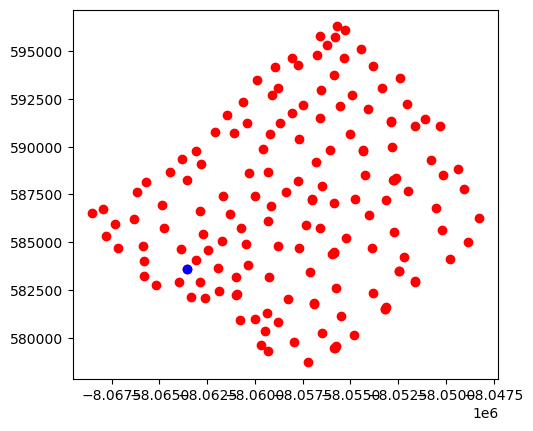

In [16]:
m= gdf.plot(color="red")
Muestra.plot(ax = m,color="blue")

In [17]:
list(Muestra.index)[0]

59

Excluimos de nuestro dataset el punto a estimar

In [18]:
gdf_vecinos = gdf[gdf.index != list(Muestra.index)[0]]

Creamos las distancia de nuestro punto de interés con respecto a los puntos que tenemos en el dataset

$
Distancia = \sqrt{(x-x_i)^{2}+(y-y_i)^{2}}
$

Donde,

$x,y$ son las coordenadas del punto a estimar <br>
$x_i,y_i$ son las coordenadas de cada punto de nuestro dataset

In [19]:
def distanciaEuclidea(x,y,x_i,y_i,n): #x,y coordenadas de datos conocidos, x_i,y_i coordenadas de dato desconocido, cantidad de datos conocidos
    x = np.array(x)
    x_i = np.array(x_i)
    y = np.array(y)
    y_i = np.array(y_i)
    DistanciaE = []
    for i in range(n):
        distancia= np.sqrt((x-x_i[i])**2 + (y-y_i[i])**2)
        DistanciaE.append(distancia)
    return DistanciaE

In [20]:
d = distanciaEuclidea(Muestra["x"],Muestra["y"], gdf_vecinos["x"],gdf_vecinos["y"],153)

In [21]:
d

[array([5745.00311725]),
 array([5381.03639658]),
 array([4774.14441233]),
 array([5024.52494164]),
 array([5152.91935968]),
 array([5741.93583009]),
 array([6179.66509471]),
 array([7312.78945214]),
 array([8330.72810747]),
 array([9228.85890214]),
 array([10543.84495981]),
 array([11549.33867028]),
 array([12341.1014867]),
 array([14057.59864257]),
 array([14938.37867745]),
 array([14989.10925083]),
 array([14402.32631276]),
 array([13827.99847071]),
 array([13104.49434441]),
 array([12166.29302041]),
 array([10585.45760187]),
 array([10126.29464034]),
 array([8250.33061158]),
 array([7498.21312142]),
 array([5513.86074264]),
 array([4650.68795678]),
 array([3583.40384263]),
 array([3797.39478539]),
 array([4422.67929423]),
 array([4583.77034275]),
 array([3741.13021979]),
 array([2618.52551788]),
 array([2411.52897042]),
 array([3077.41547924]),
 array([4235.61488084]),
 array([5983.05305886]),
 array([7440.77454984]),
 array([8305.42107258]),
 array([9050.8314307]),
 array([9822.67

Ahora definimos la función IDW en función de nuestro dataset, las distancias, el número de vecinos, la potencia, y el nombre del parámetro que vamos a estimar

In [22]:
def IDW(df,distancias,Nvecinos,p,z_col):
    df["distancias"] = distancias
    df = df.set_index("distancias")
    df = df.sort_index(axis=0)
    df_f = df.iloc[0:Nvecinos,:]
    w = 1/np.array(df_f.index**p)
    z = df_f[z_col]
    IDW = (w*z).sum() / w.sum()
    return IDW

In [23]:
zEstimada = IDW(gdf_vecinos, d, 4, 2, "altitude (m)")

In [24]:
zEstimada[0]

266.8943952415805

Estimemos el error con 4 vecinos y una potencia de 2

In [25]:
Error = np.abs(Muestra["altitude (m)"] - zEstimada)
print(Error, "metros")

59    0.194395
Name: altitude (m), dtype: float64 metros


Evaluemos el punto que queremo estimar con 9 vecinos y potencias de 1, 2, 3, 4 y 5

In [26]:
#Potencia 1
z_vi_1 = []
for i in range(1,10):
    zE = IDW(gdf_vecinos, d, i, 1, "altitude (m)") 
    z_vi_1.append(zE[0])

(263.0, 270.0)

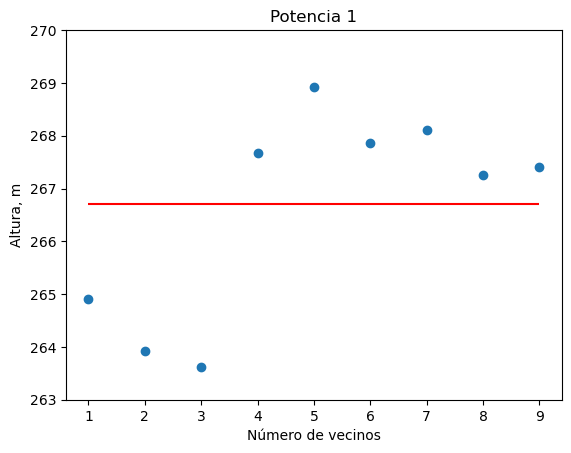

In [27]:
plt.scatter(range(1,10),np.array(z_vi_1))
plt.hlines(Muestra["altitude (m)"], 1,9, color="red")
plt.title("Potencia 1")
plt.xlabel("Número de vecinos")
plt.ylabel("Altura, m")
plt.ylim((263,270))

In [28]:
#Potencia 2
z_vi_2 = []
for i in range(1,10):
    zE = IDW(gdf_vecinos, d, i, 2, "altitude (m)") 
    z_vi_2.append(zE[0])

(263.0, 270.0)

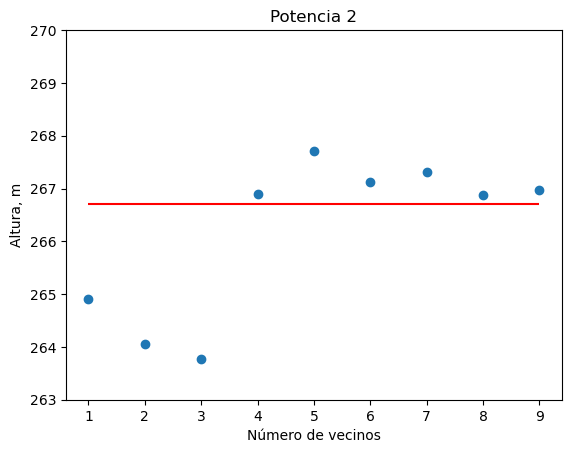

In [29]:
plt.scatter(range(1,10),np.array(z_vi_2))
plt.hlines(Muestra["altitude (m)"], 1,9, color="red")
plt.title("Potencia 2")
plt.xlabel("Número de vecinos")
plt.ylabel("Altura, m")
plt.ylim((263,270))

In [30]:
#Potencia 3
z_vi_3 = []
for i in range(1,10):
    zE = IDW(gdf_vecinos, d, i, 3, "altitude (m)") 
    z_vi_3.append(zE[0])

(263.0, 270.0)

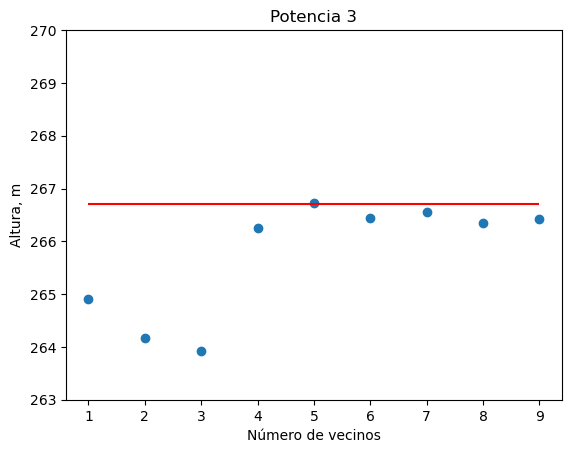

In [31]:
plt.scatter(range(1,10),np.array(z_vi_3))
plt.hlines(Muestra["altitude (m)"], 1,9, color="red")
plt.title("Potencia 3")
plt.xlabel("Número de vecinos")
plt.ylabel("Altura, m")
plt.ylim((263,270))

In [32]:
#Potencia 4
z_vi_4 = []
for i in range(1,10):
    zE = IDW(gdf_vecinos, d, i, 4, "altitude (m)") 
    z_vi_4.append(zE[0])

(263.0, 270.0)

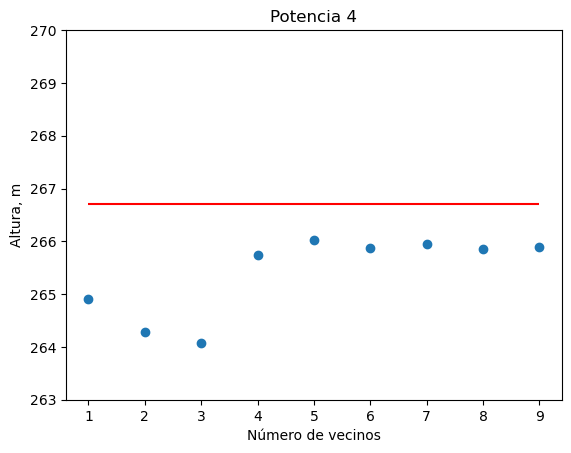

In [33]:
plt.scatter(range(1,10),np.array(z_vi_4))
plt.hlines(Muestra["altitude (m)"], 1,9, color="red")
plt.title("Potencia 4")
plt.xlabel("Número de vecinos")
plt.ylabel("Altura, m")
plt.ylim((263,270))

In [34]:
#Potencia 5
z_vi_5 = []
for i in range(1,10):
    zE = IDW(gdf_vecinos, d, i, 5, "altitude (m)") 
    z_vi_5.append(zE[0])

(263.0, 270.0)

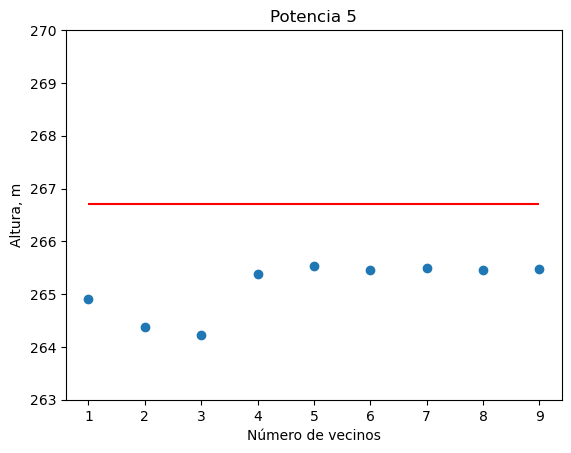

In [35]:
plt.scatter(range(1,10),np.array(z_vi_5))
plt.hlines(Muestra["altitude (m)"], 1,9, color="red")
plt.title("Potencia 5")
plt.xlabel("Número de vecinos")
plt.ylabel("Altura, m")
plt.ylim((263,270))

### Crear una grilla de puntos para interpolar con idw cada 1000 metros

In [36]:
gdf.x.max()

-8048257.4620627975

In [37]:
gdf_grid = gpd.GeoDataFrame(
    geometry=[
        shapely.geometry.Point(x, y)
        for x in np.arange(gdf.x.min(), gdf.x.max(), 1000)
        for y in np.arange(gdf.y.min(), gdf.y.max(), 1000)
    ],
    crs="3395",
)#.to_crs(gdf.crs)

<Axes: >

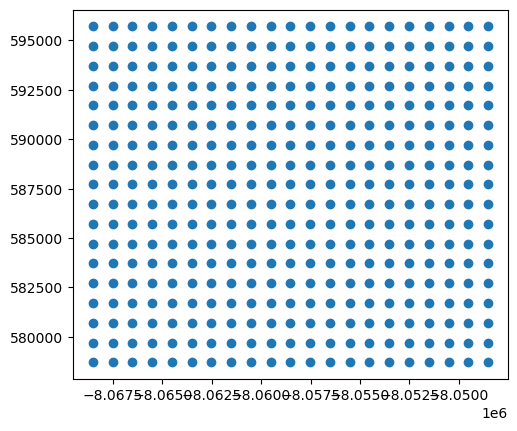

In [38]:
gdf_grid.plot()

In [39]:
gdf_grid.insert(0,"x",gdf_grid.centroid.x )
gdf_grid.insert(1,"y",gdf_grid.centroid.y )

In [40]:
gdf_grid

,x,y,geometry
0,-8.068520e+06,578707.183693,POINT (-8068519.612 578707.184)
1,-8.068520e+06,579707.183693,POINT (-8068519.612 579707.184)
2,-8.068520e+06,580707.183693,POINT (-8068519.612 580707.184)
3,-8.068520e+06,581707.183693,POINT (-8068519.612 581707.184)
4,-8.068520e+06,582707.183693,POINT (-8068519.612 582707.184)
...,...,...,...
373,-8.048520e+06,591707.183693,POINT (-8048519.612 591707.184)
374,-8.048520e+06,592707.183693,POINT (-8048519.612 592707.184)
375,-8.048520e+06,593707.183693,POINT (-8048519.612 593707.184)
376,-8.048520e+06,594707.183693,POINT (-8048519.612 594707.184)


In [41]:
gdf_grid.iloc[2,0]

-8068519.61224745

In [42]:
AlturasGrid = []

for i in range(len(gdf_grid)):
    d = distanciaEuclidea(gdf_grid.iloc[i,0],gdf_grid.iloc[i,1], gdf_vecinos["x"],gdf_vecinos["y"],153)
    idw = IDW(gdf_vecinos, d, 5, 3, "altitude (m)")
    AlturasGrid.append(idw)

In [43]:
gdf_grid.insert(2,"z",AlturasGrid)

In [44]:
gdf_grid

,x,y,z,geometry
0,-8.068520e+06,578707.183693,275.159431,POINT (-8068519.612 578707.184)
1,-8.068520e+06,579707.183693,275.632153,POINT (-8068519.612 579707.184)
2,-8.068520e+06,580707.183693,294.741142,POINT (-8068519.612 580707.184)
3,-8.068520e+06,581707.183693,298.694803,POINT (-8068519.612 581707.184)
4,-8.068520e+06,582707.183693,308.689882,POINT (-8068519.612 582707.184)
...,...,...,...,...
373,-8.048520e+06,591707.183693,266.830435,POINT (-8048519.612 591707.184)
374,-8.048520e+06,592707.183693,269.554531,POINT (-8048519.612 592707.184)
375,-8.048520e+06,593707.183693,274.332567,POINT (-8048519.612 593707.184)
376,-8.048520e+06,594707.183693,275.845302,POINT (-8048519.612 594707.184)


In [79]:
gdf_grid.explore(column="z",cmap="hsv")

In [80]:
gdf.explore(column="altitude (m)",cmap="hsv")

# Series temporales

Una serie temporal es una secuencia de datos, observaciones o valores, medidos en determinados momentos y ordenados cronológicamente. Los datos pueden estar espaciados a intervalos iguales o desiguales. 

In [47]:
st = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', index_col = 'date', parse_dates=['date'])

In [48]:
st.head()

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


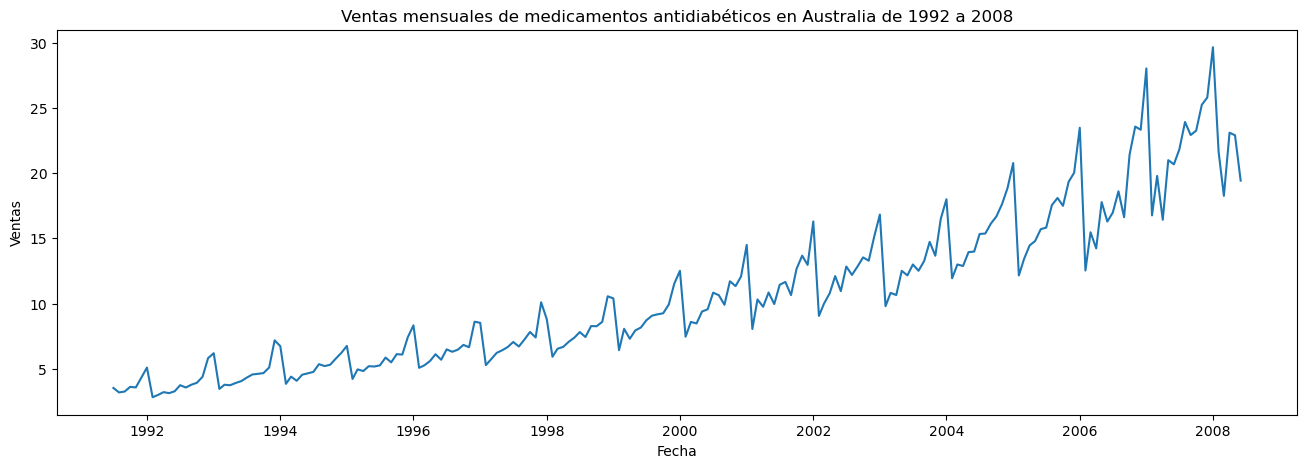

In [49]:
plt.figure(figsize=(16,5), dpi=100)
plt.plot(st.index, st["value"])
plt.gca().set(title="Ventas mensuales de medicamentos antidiabéticos en Australia de 1992 a 2008", 
              xlabel="Fecha", ylabel="Ventas")
plt.show()

La serie de tiempo puede estar compuesta por diferentes componentes que explican su comportamiento y variabilidad, como:

**La tendencia**, que es el movimiento general de la serie hacia arriba o hacia abajo a lo largo del tiempo. Refleja el crecimiento o decrecimiento a largo plazo del fenómeno. Por ejemplo, la tendencia de las ventas en la gráfica anterior es creciente.

**La estacionalidad**, que es el patrón cíclico que se repite a intervalos regulares, asociado a factores estacionales como el clima, las festividades, los hábitos de consumo, etc. Por ejemplo, la estacionalidad de las ventas de la gráfica anterior parece ser alta en diciembre y baja a inicio de año.

Vamos a descomponer nuestra serie de tiempo para conocer su tendencia y estacionalidad

In [50]:
Descomposicion = sm.tsa.seasonal_decompose(st, model="additive")

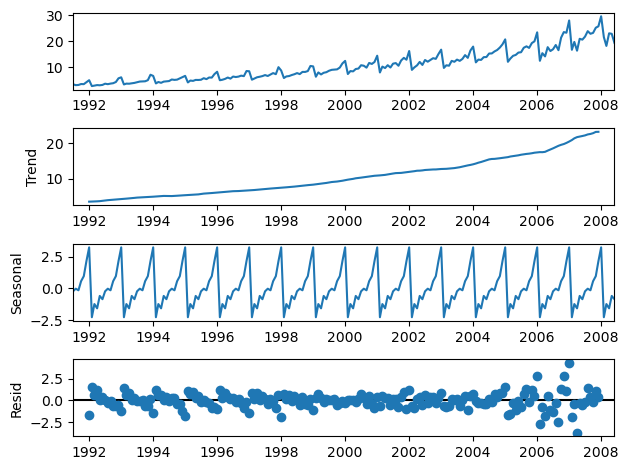

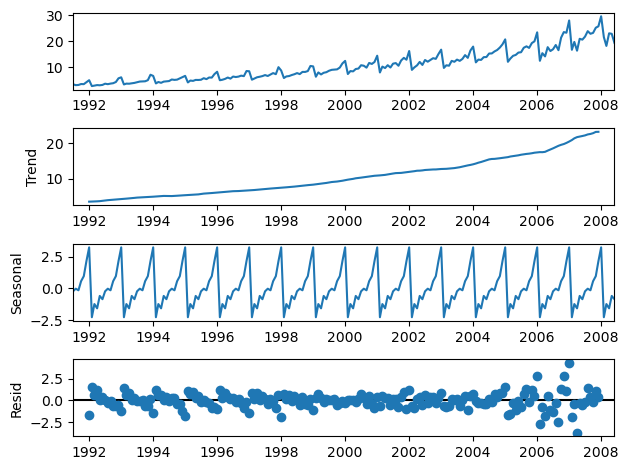

In [51]:
Descomposicion.plot()

**Los factores residuales** representan las variaciones aleatorias o irregulares que no se pueden explicar por la tendencia o la estacionalidad. Corresponden al ruido o la incertidumbre que afecta al fenómeno y que no se puede predecir con exactitud. Por ejemplo, los factores residuales de las ventas de la gráfica anterior pueden deberse a cambios imprevistos en el mercado, en la oferta, en la calidad del producto, en la publicidad, etc.

Otro aspecto a considerar es el **comportamiento cíclico**. Esto ocurre cuando el patrón de subida y bajada de la serie no ocurre en intervalos fijos basados en el calendario. Se debe tener cuidado de no confundir el efecto cíclico con el efecto estacional.

In [52]:
st.insert(0,"dias",st.index.strftime("%d"))

In [53]:
st.insert(1,"meses",st.index.strftime("%m"))

In [54]:
st.insert(2,"anios",st.index.strftime("%Y"))

In [55]:
st

,dias,meses,anios,value
date,,,,
1991-07-01,01,07,1991,3.526591
1991-08-01,01,08,1991,3.180891
1991-09-01,01,09,1991,3.252221
1991-10-01,01,10,1991,3.611003
1991-11-01,01,11,1991,3.565869
...,...,...,...,...
2008-02-01,01,02,2008,21.654285
2008-03-01,01,03,2008,18.264945
2008-04-01,01,04,2008,23.107677


<Axes: xlabel='meses', ylabel='value'>

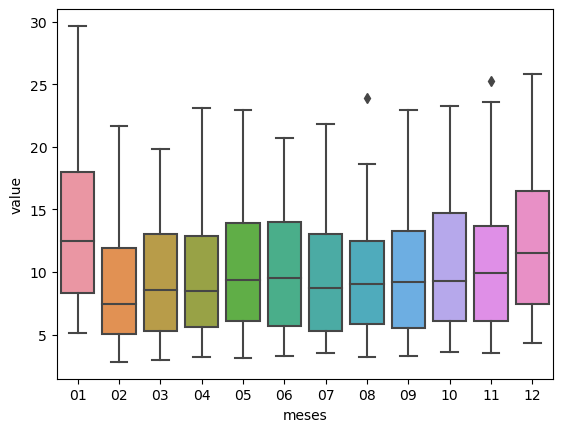

In [56]:
sns.boxplot(st, x= "meses", y= "value", order=["01","02","03","04","05","06","07","08","09","10","11","12"])

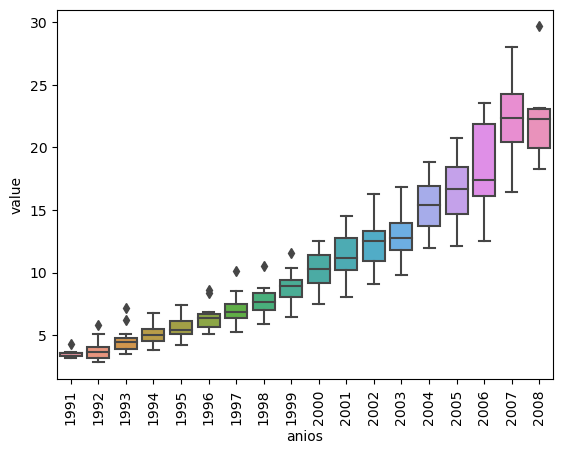

In [57]:
sns.boxplot(st, x= "anios", y= "value")
plt.xticks(rotation=90)
plt.show()

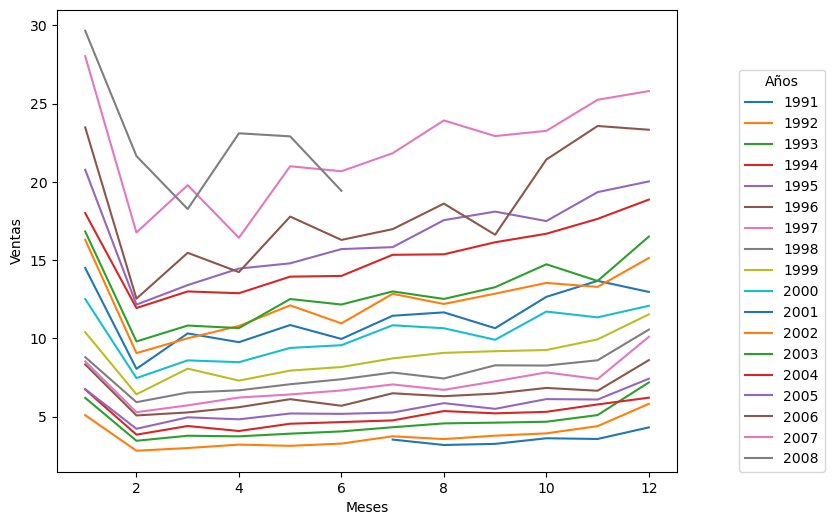

In [58]:
plt.figure(figsize=(8,6))
for i in range(1991,2009):
    filtro = st[st.anios == str(i)]
    plt.plot(filtro["meses"].astype(int),filtro.value,label=i)
    plt.legend(title="Años", loc=(1.1,0))
    plt.xlabel("Meses")
    plt.ylabel("Ventas")

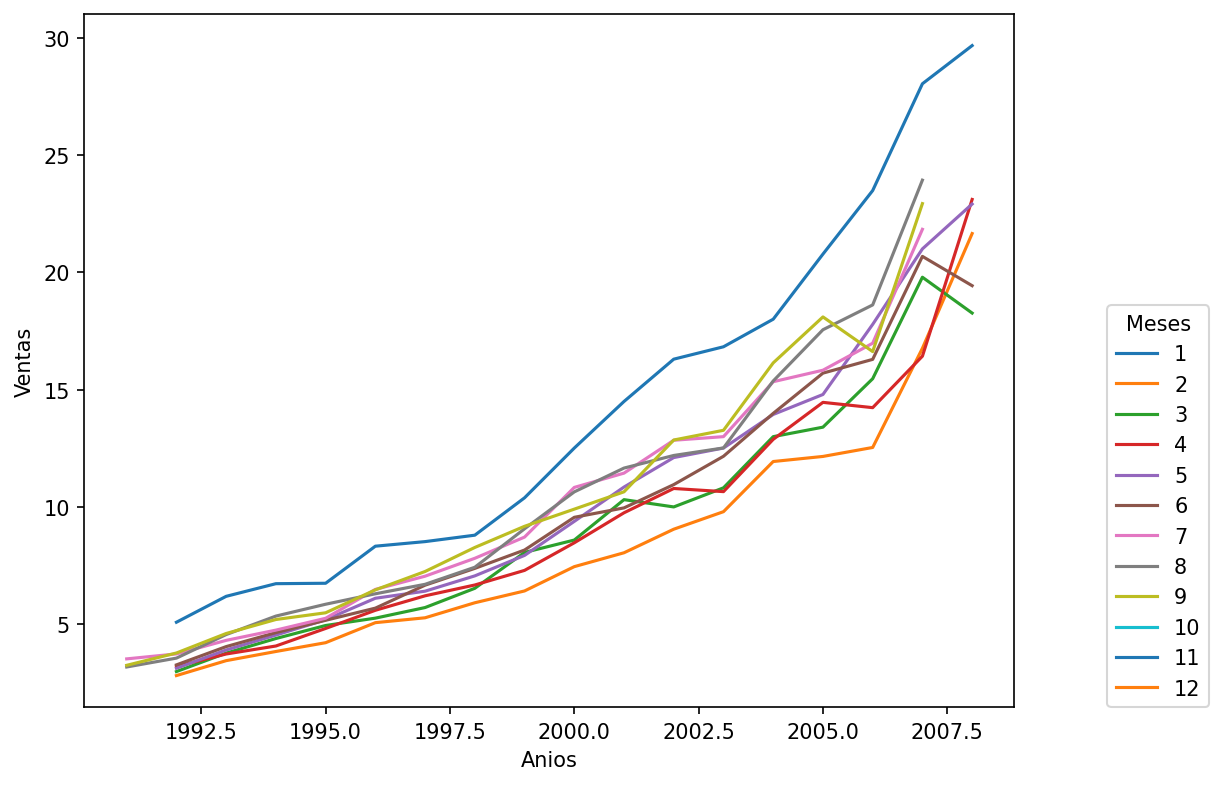

In [59]:
plt.figure(figsize=(8,6), dpi=150)
for i in range(1,13):
    filtro = st[st.meses == (str(0)+str(i))]
    plt.plot(filtro["anios"].astype(int),filtro.value,label=i)
    plt.legend(title="Meses", loc=(1.1,0))
    plt.xlabel("Anios")
    plt.ylabel("Ventas")

Hay una fuerte caída en las ventas de medicamentos cada febrero, aumentando nuevamente en marzo, cayendo nuevamente en abril. El patrón se repite cada año.

Vamos a probar la estacionaridad de nuestra serie de tiempo

Tenga en cuenta que en una **serie estacionaria** la media, varianza y autocorrelación son constantes en el tiempo.

Para verificar si la serie es estacionaria o no, podemos aplicar la prueba de Dickey Fuller aumentada (prueba ADF), cuya hipótesis nula $H_0$ afirma que la serie de tiempo no es estacionaria si el valor $p$ es > que 0.05.

In [60]:
Estacionaridad = sm.tsa.adfuller(st.value.values, autolag='AIC')

In [61]:
Estacionaridad[1] # p-valor

1.0

La serie no estacionaria

Para estacionalizar nuestra serie podemos dividir los valores de la serie por los indices de estacionalidad obtenidos anteriormente en el proceso de descomposición.

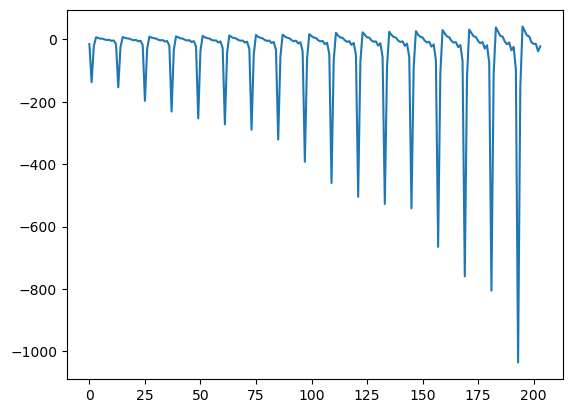

In [62]:
plt.plot(st.value.values / Descomposicion.seasonal.values)

Pronosticar una serie estacionaria es relativamente fácil y los pronósticos son más confiables.

Una razón importante es que los modelos de pronóstico autorregresivos son esencialmente modelos de regresión lineal que utilizan el o los rezagos de la propia serie como predictores.

En la regresión lineal funciona mejor si los predictores (variables X) no están correlacionados entre sí. Por lo tanto, **estacionar** una serie resuelve este problema, ya que elimina cualquier autocorrelación persistente, lo que hace que los predictores (rezagos de la serie) en los modelos de pronóstico sean casi independientes.

Ahora vamos a **eliminar el componente de tendencia** de nuestra serie de tiempo. Para eliminarlo, restamos los valores de la serie con los valores de tendencia estimados anteriormente en el proceso de descomposición.

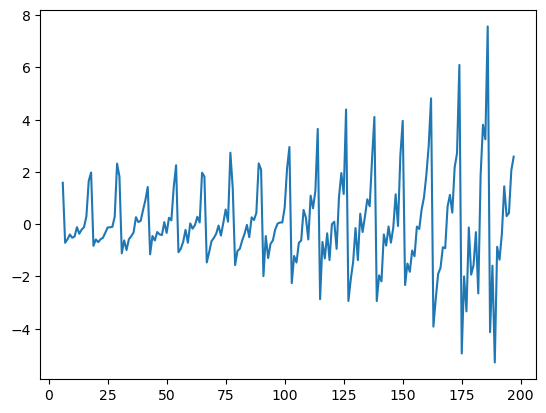

In [63]:
plt.plot(st.value.values - Descomposicion.trend.values)

## Ahora vamos a mirar como imputar valores ausentes en series temporales

In [64]:
st = st.reset_index()
np.random.seed(2)
stMuestra = st.sample(10)
stMuestra

,date,dias,meses,anios,value
25,1993-08-01,01,08,1993,4.562185
45,1995-04-01,01,04,1995,4.823045
120,2001-07-01,01,07,2001,11.443601
10,1992-05-01,01,05,1992,3.127578
176,2006-03-01,01,03,2006,15.467018
130,2002-05-01,01,05,2002,12.106705
64,1996-11-01,01,11,1996,6.649078
65,1996-12-01,01,12,1996,8.606937
94,1999-05-01,01,05,1999,7.936916
57,1996-04-01,01,04,1996,5.597126


In [65]:
stNaN = st

In [66]:
stNaN = stNaN.replace(stMuestra.value.values, np.nan)

In [67]:
stNaN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    204 non-null    datetime64[ns]
 1   dias    204 non-null    object        
 2   meses   204 non-null    object        
 3   anios   204 non-null    object        
 4   value   194 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 8.1+ KB


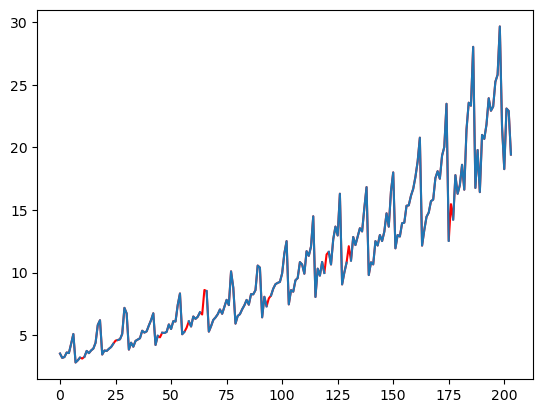

In [68]:
plt.plot(st.index, st.value, color="r")
plt.plot(stNaN.index, stNaN.value)

In [69]:
np.array(stMuestra.index.to_list())

array([ 25,  45, 120,  10, 176, 130,  64,  65,  94,  57])

### Interpolación lineal

$
y = y_{0}+\frac{y_1-y_0}{x_i - x_0} (x - x_0)
$

Donde;<br>

$y$ es el valor estimado de la función en el punto $x$ <br>
$f(x_0)$ y $f(x_1)$ son los valores conocidos de la función en los puntos $x_0$ y $x_1$ , respectivamente.

In [70]:
xy_lin = stNaN.dropna()


In [71]:
st_completa_il = np.interp(np.array(stMuestra.index.to_list()), np.array(xy_lin.index.to_list()) , np.array(xy_lin.value.to_list()))

In [72]:
st_completa_il

array([ 4.46211377,  5.07205182, 10.81047902,  3.2376515 , 13.385263  ,
       10.87142557,  7.39390993,  7.95919047,  7.73153104,  5.68642634])

In [73]:
error_il = stMuestra.value - st_completa_il
error_il

25     0.100071
45    -0.249007
120    0.633122
10    -0.110073
176    2.081755
130    1.235280
64    -0.744832
65     0.647747
94     0.205385
57    -0.089300
Name: value, dtype: float64

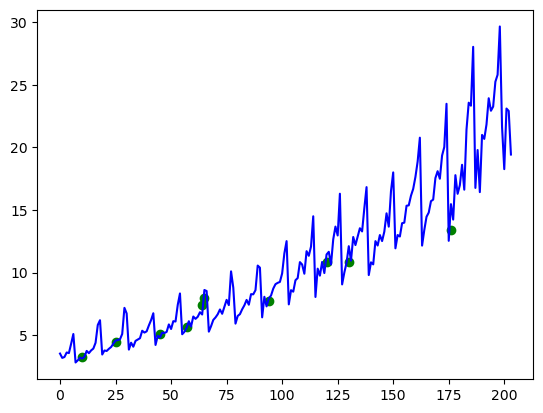

In [74]:
plt.plot(st.index, st.value, color="b")
plt.scatter(stMuestra.index, st_completa_il, color="g")

### Interpolación cública (splines cúbicos)

In [75]:
spl = scipy.interpolate.CubicSpline( np.array(xy_lin.index.to_list()) , np.array(xy_lin.value.to_list()))

In [76]:
st_completa_spl = spl(np.array(stMuestra.index.to_list())) 

In [77]:
error_spl = stMuestra.value - st_completa_spl
error_spl

25     0.061192
45    -0.602866
120    0.600556
10     0.020350
176    5.972318
130    1.764694
64    -1.675050
65    -0.985681
94     0.683225
57    -0.521278
Name: value, dtype: float64

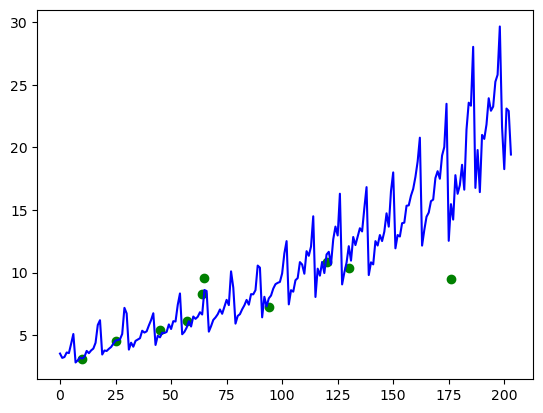

In [78]:
plt.plot(st.index, st.value, color="b")
plt.scatter(stMuestra.index, st_completa_spl, color="g")